# Importing libraries

In [1]:
import torch
import torchvision
from torch import nn
from torchvision import transforms, datasets
from torchsummary import summary
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os

# Device

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [6]:
! unzip /content/Dataset.zip

Archive:  /content/Dataset.zip
   creating: Dataset/test/
   creating: Dataset/test/cats/
  inflating: Dataset/test/cats/cat_1.jpg  
  inflating: Dataset/test/cats/cat_106.jpg  
  inflating: Dataset/test/cats/cat_109.jpg  
  inflating: Dataset/test/cats/cat_113.jpg  
  inflating: Dataset/test/cats/cat_114.jpg  
  inflating: Dataset/test/cats/cat_116.jpg  
  inflating: Dataset/test/cats/cat_118.jpg  
  inflating: Dataset/test/cats/cat_119.jpg  
  inflating: Dataset/test/cats/cat_124.jpg  
  inflating: Dataset/test/cats/cat_140.jpg  
  inflating: Dataset/test/cats/cat_147.jpg  
  inflating: Dataset/test/cats/cat_156.jpg  
  inflating: Dataset/test/cats/cat_158.jpg  
  inflating: Dataset/test/cats/cat_162.jpg  
  inflating: Dataset/test/cats/cat_18.jpg  
  inflating: Dataset/test/cats/cat_190.jpg  
  inflating: Dataset/test/cats/cat_203.jpg  
  inflating: Dataset/test/cats/cat_223.jpg  
  inflating: Dataset/test/cats/cat_234.jpg  
  inflating: Dataset/test/cats/cat_244.jpg  
  inflating: 

In [7]:
train_dir = '/content/Dataset/train'
test_dir = '/content/Dataset/test'

In [3]:
def create_dataloader(train_dir, test_dir, transform=transforms.Compose):

  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  class_names = train_data.classes

  train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
  test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False)

  return train_dataloader, test_dataloader, class_names


In [4]:
IMG_SIZE = 224

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

print(f'Manually created transforms: {manual_transforms}')

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [8]:
train_dataloader, test_dataloader, class_names = create_dataloader(
    train_dir, test_dir, manual_transforms
)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7a7571842950>,
 ['cats', 'dogs'])

In [11]:
image_batch, label_batch = next(iter(train_dataloader))

image, label = image_batch[0], label_batch[0]

print(image.shape, label)

torch.Size([3, 224, 224]) tensor(1)


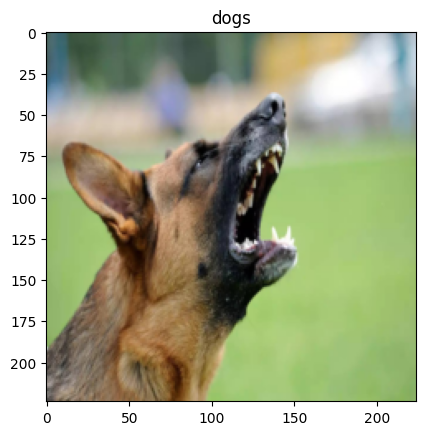

In [12]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.show()

# Vision transformer - Step 1

### Task

1. Turn an image into patches
2. Flatten the patch feature maps into a single dimension
3. Convert the output into desired output (flattened 2D patches): (196,768) --> Nx(p2.C)
4. Number of patches = (img_size/16) * (img_size/16) = 196
5. Embedding dim = 768

In [30]:
class PatchEmbedding(nn.Module):

  def __init__(self, in_channels=3, patch_size=16, embedding_dim=768):
    super().__init__()
    self.patcher = nn.Conv2d(in_channels, embedding_dim, patch_size, patch_size)
    self.flatten = nn.Flatten(start_dim=2, end_dim=3)

  def forward(self, x):
    image_resolution = x.shape[-1]
    assert image_resolution % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"
    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)
    return x_flattened.permute(0,2,1)

# Patch embedding layer

In [15]:
patch_size = 16

def set_seeds(seed=42):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)

set_seeds()

In [31]:
patchify = PatchEmbedding(3, 16, 768)

print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0))
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [20]:
type(patch_embedded_image)

torch.Tensor

In [32]:
# 1. set patch size

patch_size = 16

# 2. print shape of original image tensor

print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. get image tensor and add batch dim

x = image.unsqueeze(0)
print(f"input image with batch dimension shape: {x.shape}")

# 4. create patch embedding layer

patch_embedding_layer = PatchEmbedding(3,16, 768)

# 5. Pass image through patch embedding layer

patch_embedding = patch_embedding_layer(x)
print(f"patching embedding shape:{patch_embedding.shape}")

# 6. Create class token embedding

batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), requires_grad=True)
print(f"class token embedding shape: {class_token.shape}")


# 7. prepend class token embedding to patch embeddings

patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding

number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# 9. Add position embedding to patch embedding with class token

patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")


print(patch_embedding_class_token)

Image tensor shape: torch.Size([3, 224, 224])
input image with batch dimension shape: torch.Size([1, 3, 224, 224])
patching embedding shape:torch.Size([1, 196, 768])
class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])
tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 0.3106,  0.2770,  0.1093,  ..., -0.4648, -0.3386,  0.2205],
         [ 0.2953,  0.2245,  0.0772,  ..., -0.3438, -0.2063,  0.1901],
         ...,
         [ 0.5462,  0.5465,  0.2228,  ..., -0.6278, -0.4000,  0.4418],
         [ 0.5295,  0.5331,  0.2083,  ..., -0.6111, -0.3719,  0.4245],
         [ 0.5058,  0.5177,  0.1933,  ..., -0.5932, -0.3565,  0.4157]]],
       grad_fn=<CatBackward0>)


# Transformer Encoder

`torch.nn.LayerNorm()` - Normalizes an input over the last dim.

It helps to impove the training time and model generalization

`torch.nn.MulitheadAttention()` - Mutli head self attention (MSA)

embed_dim = the embedding dime

num_heads = how many attention heads

dropout = whether or not to apply dropout to the attention layer

batch_First = batch dim comes first?

In [33]:
class MultiheadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block ("MSA block" for short).
    """
    # 2. Initialize the class with hyperparameters from Table 1
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0): # doesn't look like the paper uses any dropout in MSABlocks
        super().__init__()

        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Create the Multi-Head Attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True) # does our batch dimension come first?

    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, # query embeddings
                                             key=x, # key embeddings
                                             value=x, # value embeddings
                                             need_weights=False) # do we need the weights or just the layer outputs?
        return attn_output

# MLP Block

In [34]:
class MLPBlock(nn.Module):
    """Creates a layer normalized multilayer perceptron block ("MLP block" for short)."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden Size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 dropout:float=0.1): # Dropout from Table 3 for ViT-Base
        super().__init__()

        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Create the Multilayer perceptron (MLP) layer(s)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(), # "The MLP contains two layers with a GELU non-linearity (section 3.1)."
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, # needs to take same in_features as out_features of layer above
                      out_features=embedding_dim), # take back to embedding_dim
            nn.Dropout(p=dropout) # "Dropout, when used, is applied after every dense layer.."
        )

    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

# Transformer Encoder by combining custom made layers

In [35]:
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 mlp_dropout:float=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                 attn_dropout:float=0): # Amount of dropout for attention layers
        super().__init__()

        # 3. Create MSA block (equation 2)
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)

        # 4. Create MLP block (equation 3)
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)

    # 5. Create a forward() method
    def forward(self, x):

        # 6. Create residual connection for MSA block (add the input to the output)
        x =  self.msa_block(x) + x

        # 7. Create residual connection for MLP block (add the input to the output)
        x = self.mlp_block(x) + x

        return x

In [26]:
! pip install torchinfo

In [36]:
transformer_encoder_block = TransformerEncoderBlock()

from torchinfo import summary
# # Print an input and output summary of our Transformer Encoder (uncomment for full output)
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

# Vision Transformer

In [37]:
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 img_size:int=224, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0, # Dropout for attention projection
                 mlp_dropout:float=0.1, # Dropout for dense/MLP layers
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 num_classes:int=1000): # Default for ImageNet but can customize this
        super().__init__() # don't forget the super().__init__()!

        # 3. Make the image size is divisble by the patch size
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

        # 4. Calculate number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2

        # 5. Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)

        # 6. Create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)

        # 7. Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # 8. Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)

        # 9. Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential())
        # Note: The "*" means "all"
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

        # 10. Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )

    # 11. Create a forward() method
    def forward(self, x):

        # 12. Get batch size
        batch_size = x.shape[0]

        # 13. Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

        # 14. Create patch embedding (equation 1)
        x = self.patch_embedding(x)

        # 15. Concat class embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)

        # 16. Add position embedding to patch embedding (equation 1)
        x = self.position_embedding + x

        # 17. Run embedding dropout (Appendix B.1)
        x = self.embedding_dropout(x)

        # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_encoder(x)

        # 19. Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x

# Train model

In [38]:
vit = ViT(num_classes=len(class_names))

In [39]:
!unzip /content/going_modular.zip

Archive:  /content/going_modular.zip
   creating: going_modular/__pycache__/
  inflating: going_modular/__pycache__/engine.cpython-311.pyc  
  inflating: going_modular/engine.py  
  inflating: going_modular/model_builder.py  
  inflating: going_modular/predictions.py  
  inflating: going_modular/train.py  
  inflating: going_modular/utils.py  


In [41]:
from going_modular import engine

# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=3e-3, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds
set_seeds()

# Train the model and save the training results to a dictionary
results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0753 | train_acc: 0.4709 | test_loss: 0.7777 | test_acc: 0.4375
Epoch: 2 | train_loss: 0.7192 | train_acc: 0.5091 | test_loss: 0.6978 | test_acc: 0.5625
Epoch: 3 | train_loss: 0.7110 | train_acc: 0.5015 | test_loss: 0.7014 | test_acc: 0.4375
Epoch: 4 | train_loss: 0.7075 | train_acc: 0.4675 | test_loss: 0.6969 | test_acc: 0.4375
Epoch: 5 | train_loss: 0.7099 | train_acc: 0.5004 | test_loss: 0.6853 | test_acc: 0.5625


In [42]:
PATH = 'cat&dogs.pth'
torch.save(vit.state_dict(), PATH)

In [45]:
test_dataloader

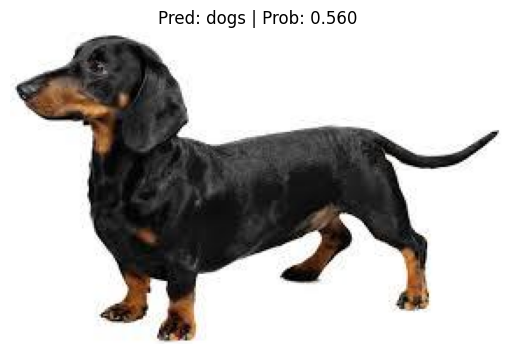

In [47]:
import requests

# Import function to make predictions on images and plot them
from going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "/content/Dataset/test/dogs/dog_124.jpg"

# Predict on custom image
pred_and_plot_image(model=vit,
                    image_path=custom_image_path,
                    class_names=class_names)